In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
from PIL import Image
import torch
from torch import nn
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, ConcatDataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pickle
import warnings
import albumentations as A

warnings.filterwarnings('ignore')

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA

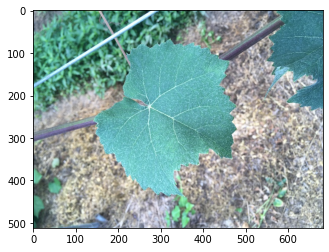

In [2]:
sample = glob('data/train/*')[np.random.randint(0, 1000)]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
sample_csv = pd.read_csv(r'data/train/10045/10045.csv')
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-09-15 16:10:00,28.4,28.6,28.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-09-15 16:00:00,29.2,29.5,28.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-09-15 15:50:00,29.4,29.6,29.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-09-15 15:40:00,29.1,29.2,28.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-09-15 15:30:00,29.0,29.2,28.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-09-13 16:00:00,28.3,28.6,28.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
290,2021-09-13 15:50:00,28.6,28.6,28.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
291,2021-09-13 15:40:00,28.4,28.6,28.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
292,2021-09-13 15:30:00,28.9,29.1,28.7,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [4]:
# # image
# plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
# plt.show()

In [5]:
# json
sample_json

{'description': {'date': '20210714',
  'image': '11936.jpg',
  'task': 0,
  'width': 682,
  'time': '0954',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': '00',
  'grow': 24,
  'bbox': [{'x': 141.40952587632276,
    'h': 373.02856316137564,
    'y': 67.65714389054233,
    'w': 338.8952546296296}],
  'part': [],
  'risk': 0,
  'crop': 6}}

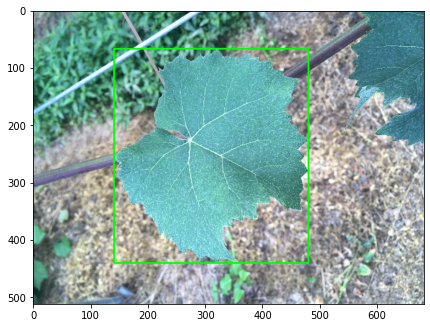

In [6]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

In [7]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
'내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'] #, '내부 CO2 평균', '내부 CO2 최고', '내부 CO2 최저']

csv_files = sorted(glob('data/train/*/*.csv'))

# 환경 데이터 통계량 계산 for MinMax Scaling

In [8]:
# ## ADDED

# lens = []
# total_sum = 0
# total_cnt = 0

# temp_csv = pd.read_csv(csv_files[0])[csv_features]
# temp_csv = temp_csv.replace('-',np.nan).dropna() 
# temp_csv = temp_csv.astype(float)
# max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
# total_sum += temp_csv.sum().to_numpy()
# total_cnt+=1

# # feature 별 최대값, 최솟값 계산
# for csv in tqdm(csv_files[1:]):
#     temp_csv = pd.read_csv(csv)[csv_features]
#     temp_csv = temp_csv.replace('-', np.nan).dropna()
#     lens.append(len(temp_csv))
#     if len(temp_csv) == 0:
#         continue    # nan값이면 최대, 최솟값 계산하지 않음
#     temp_csv = temp_csv.astype(float)
#     temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
#     temp_sum = temp_csv.sum().to_numpy()
#     temp_cnt = len(temp_csv)

#     total_sum += temp_sum
#     total_cnt += temp_cnt

#     max_arr = np.max([max_arr,temp_max], axis=0)
#     min_arr = np.min([min_arr,temp_min], axis=0)

# # feature 별 최대값, 최솟값 dictionary 생성
# csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}

# # ADDED # feature 별 평균의 dict 생성 
# csv_means = total_sum/total_cnt
# csv_feature_mean_dict = {csv_features[i]:csv_means[i] for i in range(len(csv_features))}

# # save data
# with open('csv_feature_dict.pkl','wb') as fw:
#     pickle.dump(csv_feature_dict, fw)

# with open('csv_feature_mean_dict.pkl','wb') as fw:
#     pickle.dump(csv_feature_mean_dict, fw)

In [9]:
# temp_csv

In [10]:
# pd.DataFrame(lens).value_counts()

In [11]:
# load data

with open('csv_feature_dict.pkl', 'rb') as fr:
    csv_feature_dict = pickle.load(fr)

with open('csv_feature_mean_dict.pkl', 'rb') as fr:
    csv_feature_mean_dict = pickle.load(fr)

print(csv_feature_dict)
print(csv_feature_mean_dict)

{'내부 온도 1 평균': [3.4, 47.3], '내부 온도 1 최고': [3.4, 47.6], '내부 온도 1 최저': [3.3, 47.0], '내부 습도 1 평균': [23.7, 100.0], '내부 습도 1 최고': [25.9, 100.0], '내부 습도 1 최저': [0.0, 100.0], '내부 이슬점 평균': [0.1, 34.5], '내부 이슬점 최고': [0.2, 34.7], '내부 이슬점 최저': [0.0, 34.4]}
{'내부 온도 1 평균': 20.68236712855918, '내부 온도 1 최고': 20.826133211812305, '내부 온도 1 최저': 20.532250333338887, '내부 습도 1 평균': 79.30295313001012, '내부 습도 1 최고': 80.1790475226017, '내부 습도 1 최저': 78.42933861049711, '내부 이슬점 평균': 16.663928617641908, '내부 이슬점 최고': 16.95606800677366, '내부 이슬점 최저': 16.373912752395313}


# CustomDataset 제작

In [12]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'} 

In [13]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

In [14]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

# Augmentation

In [15]:
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    A.Resize(380, 380, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(),
    A.GaussNoise(p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit = 3, p = 0.2),
        A.MedianBlur(blur_limit = 3, p = 0.1),
        A.Blur(blur_limit = 3, p = 0.1),
        ], p = 0.2),
    A.ShiftScaleRotate(rotate_limit = 30),
    A.OneOf([
        A.OpticalDistortion(p = 1.0),
        A.GridDistortion(p = 1.0),
        ], p = 0.3),
    A.OneOf([
        A.CLAHE(clip_limit = 2),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    # A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    A.Normalize(),
    ToTensorV2()
])

else_transform = A.Compose([
    A.Resize(380, 380, interpolation=cv2.INTER_AREA),
    # A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    A.Normalize(),
    ToTensorV2()
])

In [16]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = max_len
        self.label_encoder = label_encoder
        # self.img_transform = transform # ADDED

    def __len__(self):
        return len(self.files)

    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]

            # ADDED 
            # 쓸 feature에 대해서만 평균값으로 imputation 진행 
            for key in self.csv_feature_dict.keys():
                df[key] = df[key].replace('-', csv_feature_mean_dict[key])
            # df = df.replace('-', 0) ###Original###

            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:] # max_len 까지만 df 사용, 그 이전은 0  
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        # print(len(csv_feature))

        # image
        image_path = f'{file}/{file_name}.jpg'

        img = Image.open(image_path)
        img = np.asarray(img)
    
        if self.mode != 'test':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
                
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            if self.mode == 'train':
                img = train_transform(image=img)['image']
                
            elif self.mode == 'val':
                img = else_transform(image=img)['image']

            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }

        else:

            img = else_transform(image=img)['image']
            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# Hyperparameter

In [17]:
device = torch.device("cuda:0")
train_batch_size = 16
else_batch_size = 32
class_n = len(label_encoder)
learning_rate = 1e-5 * train_batch_size
embedding_dim = 512     # RNN hidden
num_features = len(csv_feature_dict)   # '내부 온도 1 평균' ~ '내부 이슬점 최저'
max_len = 144

# CNN

# RNN
rnn_fc_dim = 1000
fc_dropout_rate = 0.2
epochs = 100

# Save 설정
save_name = 'JS_effb4+LSTM_v1'
save_path = f'models/{save_name}.pt'
print(f'class수 : {class_n}')
print(f'feature 수: {num_features}')
print(save_name)
print(save_path)

class수 : 111
feature 수: 9
JS_effb4+LSTM_v1
models/JS_effb4+LSTM_v1.pt


# 데이터셋 구성

In [18]:
train = sorted(glob('data/train/*'))
test = sorted(glob('data/test/*'))

labelsss = pd.read_csv('data/train_gt.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [19]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val, mode = 'val')
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=else_batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=else_batch_size, shuffle=False)

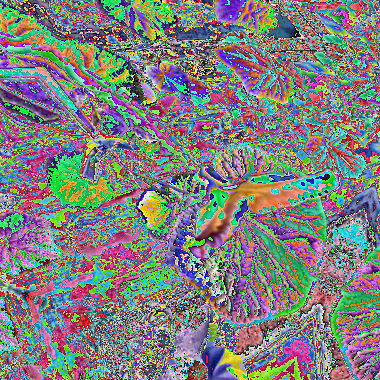

In [34]:
toimage = transforms.ToPILImage()
toimage(train_dataset[np.random.randint(1, 1000)]['img'])

# 모델

## 이미지 분류 모델 : EfficientNetb4

In [23]:
from torchvision.models import efficientnet_b4

class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate=0.2):
        super(CNN_Encoder, self).__init__()
        self.model = efficientnet_b4(pretrained=True)    # (input, output) = (380, 1792)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [24]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, rnn_fc_dim)
        self.final_layer = nn.Linear(1000+rnn_fc_dim, class_n) # cnn out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp) # hidden dim : (Batch, csv_feature, embedding_dim)
        hidden = hidden.view(hidden.size(0), -1)    # (Batch, num_features*embedding_dim)
        hidden = self.rnn_fc(hidden)    # (, 1000)

        fc_input = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        output = self.final_layer(fc_input)
        output = self.dropout(output)
        return output

## 앙상블

In [25]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)  # concat - 1000+1000
        
        return output

In [26]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)
model = model.to(device)

In [25]:
# hidden dim : (Batch, csv_feature, embedding_dim)
# final output : (Batch, n_class)
# model = model.cpu()
# sample_batch = next(iter(train_dataloader))
# sample_img = sample_batch['img']
# sample_csv = sample_batch['csv_feature']
# sample_out = model(sample_img, sample_csv)
# sample_out
# OUT SHAPE : (16, 111)
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2000 and 2792x111)

In [27]:
import gc
gc.collect()

6090

# 학습

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(reduction='mean')
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold = 0.1, patience=10, threshold_mode='rel', verbose=True)

In [28]:
import torch.nn as nn

def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train(model, loader, epoch, nb_epochs):
    print(f'Epoch {epoch+1}/{nb_epochs}')
    running_loss = 0.0
    running_score = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    for idx, batch in enumerate(tqdm(loader)):
        img = batch['img'].to(device)
        csv_feature = batch['csv_feature'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)

        scaler.scale(loss).backward() # ADDED - mixed precision + gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        scaler.step(optimizer)
        scaler.update()

        score = accuracy_function(label, output)
        pred = torch.argmax(output, dim=1)

        running_loss += loss.item() 
        running_score ++ score
        running_corrects += torch.sum(label==pred)
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_score = running_corrects / len(loader.dataset)
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('F1_score/train', epoch_score, epoch)
    # writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train F1: {epoch_score:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')
    # print(f"{running_corrects}/{len(loader.dataset)} correct")

def validate(model, loader, epoch, nb_epochs):
    running_loss = 0.0
    running_score = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].to(device)
            csv_feature = batch['csv_feature'].to(device)
            label = batch['label'].to(device)
            output = model(img, csv_feature)
            loss = criterion(output, label)
            score = accuracy_function(label, output)
            pred = torch.argmax(output, dim=1)
            
            running_loss += loss.item() 
            running_score += score
            running_corrects += torch.sum(label==pred)
            
        epoch_loss = running_loss / len(loader.dataset)
        epoch_score = running_corrects / len(loader.dataset)
        # scheduler.step(epoch_loss)
        writer.add_scalar('Loss/valid', epoch_loss, epoch)
        writer.add_scalar('F1_score/valid', epoch_score, epoch)
        # writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
        print("Val loss: {:.6f}, Val F1: {:.6f}".format(epoch_loss, epoch_score)) # lr: {optimizer.param_groups[0]["lr"]:.6f}')
        print(f"{running_corrects}/{len(loader.dataset)} correct")

        epoch_score = epoch_score.detach().cpu().numpy()
        val_score_list.append(epoch_score)
        
        if np.max(val_score_list) == val_score_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)


In [29]:
from torch.utils.tensorboard import SummaryWriter
import os
import math

writer = SummaryWriter(log_dir='logs/' + save_name)
val_score_list = []

for epoch in range(epochs):
    train(model, train_dataloader, epoch, epochs)
    validate(model, val_dataloader, epoch, epochs) 

Epoch 1/100


100%|██████████| 289/289 [04:05<00:00,  1.18it/s]


Train loss: 0.136742, Train F1: 0.489703, lr: 0.000100
Val loss: 0.023510, Val F1: 0.788562
910/1154 correct
Epoch 2/100


100%|██████████| 289/289 [03:25<00:00,  1.41it/s]


Train loss: 0.086787, Train F1: 0.653804, lr: 0.000100
Val loss: 0.013502, Val F1: 0.881283
1017/1154 correct
Epoch 3/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.074093, Train F1: 0.698894, lr: 0.000100
Val loss: 0.008827, Val F1: 0.902080
1041/1154 correct
Epoch 4/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.063971, Train F1: 0.740516, lr: 0.000100
Val loss: 0.006748, Val F1: 0.924610
1067/1154 correct
Epoch 5/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.060405, Train F1: 0.758075, lr: 0.000100
Val loss: 0.005552, Val F1: 0.943674
1089/1154 correct
Epoch 6/100


100%|██████████| 289/289 [03:25<00:00,  1.41it/s]


Train loss: 0.058414, Train F1: 0.763711, lr: 0.000100
Val loss: 0.005246, Val F1: 0.938475
1083/1154 correct
Epoch 7/100


100%|██████████| 289/289 [03:30<00:00,  1.37it/s]


Train loss: 0.056700, Train F1: 0.770648, lr: 0.000100
Val loss: 0.004528, Val F1: 0.947140
1093/1154 correct
Epoch 8/100


100%|██████████| 289/289 [03:27<00:00,  1.39it/s]


Train loss: 0.056465, Train F1: 0.768264, lr: 0.000100
Val loss: 0.004085, Val F1: 0.951473
1098/1154 correct
Epoch 9/100


100%|██████████| 289/289 [03:27<00:00,  1.40it/s]


Train loss: 0.052763, Train F1: 0.784522, lr: 0.000100
Val loss: 0.004300, Val F1: 0.951473
1098/1154 correct
Epoch 10/100


100%|██████████| 289/289 [03:28<00:00,  1.39it/s]


Train loss: 0.052850, Train F1: 0.789725, lr: 0.000100
Val loss: 0.003054, Val F1: 0.961872
1110/1154 correct
Epoch 11/100


100%|██████████| 289/289 [03:27<00:00,  1.39it/s]


Train loss: 0.050601, Train F1: 0.800347, lr: 0.000100
Val loss: 0.003579, Val F1: 0.955806
1103/1154 correct
Epoch 12/100


100%|██████████| 289/289 [03:27<00:00,  1.39it/s]


Train loss: 0.049653, Train F1: 0.793193, lr: 0.000100
Val loss: 0.003483, Val F1: 0.959272
1107/1154 correct
Epoch 13/100


100%|██████████| 289/289 [03:27<00:00,  1.40it/s]


Train loss: 0.048712, Train F1: 0.804032, lr: 0.000100
Val loss: 0.003813, Val F1: 0.954939
1102/1154 correct
Epoch 14/100


100%|██████████| 289/289 [03:27<00:00,  1.39it/s]


Train loss: 0.049327, Train F1: 0.801214, lr: 0.000100
Val loss: 0.003236, Val F1: 0.964471
1113/1154 correct
Epoch 15/100


100%|██████████| 289/289 [03:27<00:00,  1.39it/s]


Train loss: 0.048501, Train F1: 0.806417, lr: 0.000100
Val loss: 0.002999, Val F1: 0.962738
1111/1154 correct
Epoch 16/100


100%|██████████| 289/289 [03:29<00:00,  1.38it/s]


Train loss: 0.046972, Train F1: 0.808801, lr: 0.000100
Val loss: 0.003020, Val F1: 0.968804
1118/1154 correct
Epoch 17/100


100%|██████████| 289/289 [03:25<00:00,  1.41it/s]


Train loss: 0.049167, Train F1: 0.801431, lr: 0.000100
Val loss: 0.003493, Val F1: 0.967071
1116/1154 correct
Epoch 18/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.049891, Train F1: 0.794060, lr: 0.000100
Val loss: 0.003460, Val F1: 0.969671
1119/1154 correct
Epoch 19/100


100%|██████████| 289/289 [03:22<00:00,  1.42it/s]


Train loss: 0.044968, Train F1: 0.813137, lr: 0.000100
Val loss: 0.004369, Val F1: 0.962738
1111/1154 correct
Epoch 20/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.047057, Train F1: 0.809018, lr: 0.000100
Val loss: 0.004132, Val F1: 0.961005
1109/1154 correct
Epoch 21/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.049006, Train F1: 0.800130, lr: 0.000100
Val loss: 0.004660, Val F1: 0.963605
1112/1154 correct
Epoch 22/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.046233, Train F1: 0.808584, lr: 0.000100
Val loss: 0.006336, Val F1: 0.955806
1103/1154 correct
Epoch 23/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.048944, Train F1: 0.801431, lr: 0.000100
Val loss: 0.005356, Val F1: 0.973137
1123/1154 correct
Epoch 24/100


100%|██████████| 289/289 [03:22<00:00,  1.42it/s]


Train loss: 0.048968, Train F1: 0.808584, lr: 0.000100
Val loss: 0.006183, Val F1: 0.967938
1117/1154 correct
Epoch 25/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.045514, Train F1: 0.818556, lr: 0.000100
Val loss: 0.006107, Val F1: 0.962738
1111/1154 correct
Epoch 26/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.047186, Train F1: 0.810102, lr: 0.000100
Val loss: 0.006124, Val F1: 0.970537
1120/1154 correct
Epoch 27/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.048103, Train F1: 0.807284, lr: 0.000100
Val loss: 0.006489, Val F1: 0.967071
1116/1154 correct
Epoch 28/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.047649, Train F1: 0.817689, lr: 0.000100
Val loss: 0.007343, Val F1: 0.970537
1120/1154 correct
Epoch 29/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.045434, Train F1: 0.823325, lr: 0.000100
Val loss: 0.007724, Val F1: 0.965338
1114/1154 correct
Epoch 30/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.047477, Train F1: 0.807501, lr: 0.000100
Val loss: 0.006760, Val F1: 0.968804
1118/1154 correct
Epoch 31/100


100%|██████████| 289/289 [03:22<00:00,  1.42it/s]


Train loss: 0.049080, Train F1: 0.808801, lr: 0.000100
Val loss: 0.007402, Val F1: 0.971404
1121/1154 correct
Epoch 32/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.045881, Train F1: 0.820291, lr: 0.000100
Val loss: 0.009044, Val F1: 0.972270
1122/1154 correct
Epoch 33/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.044878, Train F1: 0.821374, lr: 0.000100
Val loss: 0.011716, Val F1: 0.963605
1112/1154 correct
Epoch 34/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.046085, Train F1: 0.809885, lr: 0.000100
Val loss: 0.011239, Val F1: 0.968804
1118/1154 correct
Epoch 35/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.047452, Train F1: 0.810752, lr: 0.000100
Val loss: 0.011078, Val F1: 0.967938
1117/1154 correct
Epoch 36/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.042582, Train F1: 0.827661, lr: 0.000100
Val loss: 0.013081, Val F1: 0.964471
1113/1154 correct
Epoch 37/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.046555, Train F1: 0.818990, lr: 0.000100
Val loss: 0.013375, Val F1: 0.965338
1114/1154 correct
Epoch 38/100


100%|██████████| 289/289 [03:24<00:00,  1.41it/s]


Train loss: 0.044425, Train F1: 0.819207, lr: 0.000100
Val loss: 0.013382, Val F1: 0.969671
1119/1154 correct
Epoch 39/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.041809, Train F1: 0.831997, lr: 0.000100
Val loss: 0.016151, Val F1: 0.967071
1116/1154 correct
Epoch 40/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.043390, Train F1: 0.826360, lr: 0.000100
Val loss: 0.015534, Val F1: 0.967071
1116/1154 correct
Epoch 41/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.043557, Train F1: 0.820074, lr: 0.000100
Val loss: 0.016015, Val F1: 0.969671
1119/1154 correct
Epoch 42/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.044756, Train F1: 0.821808, lr: 0.000100
Val loss: 0.016091, Val F1: 0.970537
1120/1154 correct
Epoch 43/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.043269, Train F1: 0.821591, lr: 0.000100
Val loss: 0.015431, Val F1: 0.965338
1114/1154 correct
Epoch 44/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.045576, Train F1: 0.817039, lr: 0.000100
Val loss: 0.014796, Val F1: 0.972270
1122/1154 correct
Epoch 45/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.046166, Train F1: 0.815955, lr: 0.000100
Val loss: 0.017143, Val F1: 0.963605
1112/1154 correct
Epoch 46/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.042957, Train F1: 0.824843, lr: 0.000100
Val loss: 0.016196, Val F1: 0.970537
1120/1154 correct
Epoch 47/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.042070, Train F1: 0.817256, lr: 0.000100
Val loss: 0.019346, Val F1: 0.972270
1122/1154 correct
Epoch 48/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.041216, Train F1: 0.825276, lr: 0.000100
Val loss: 0.021126, Val F1: 0.967938
1117/1154 correct
Epoch 49/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.043566, Train F1: 0.828311, lr: 0.000100
Val loss: 0.032142, Val F1: 0.961872
1110/1154 correct
Epoch 50/100


100%|██████████| 289/289 [03:22<00:00,  1.42it/s]


Train loss: 0.041812, Train F1: 0.830262, lr: 0.000100
Val loss: 0.022825, Val F1: 0.966205
1115/1154 correct
Epoch 51/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.041824, Train F1: 0.824843, lr: 0.000100
Val loss: 0.026439, Val F1: 0.969671
1119/1154 correct
Epoch 52/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.039241, Train F1: 0.835899, lr: 0.000100
Val loss: 0.022395, Val F1: 0.968804
1118/1154 correct
Epoch 53/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.041573, Train F1: 0.825493, lr: 0.000100
Val loss: 0.020751, Val F1: 0.974870
1125/1154 correct
Epoch 54/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.041247, Train F1: 0.826794, lr: 0.000100
Val loss: 0.024052, Val F1: 0.970537
1120/1154 correct
Epoch 55/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.042325, Train F1: 0.827878, lr: 0.000100
Val loss: 0.019308, Val F1: 0.972270
1122/1154 correct
Epoch 56/100


100%|██████████| 289/289 [03:21<00:00,  1.43it/s]


Train loss: 0.038908, Train F1: 0.839584, lr: 0.000100
Val loss: 0.022384, Val F1: 0.974003
1124/1154 correct
Epoch 57/100


100%|██████████| 289/289 [03:22<00:00,  1.43it/s]


Train loss: 0.040096, Train F1: 0.836115, lr: 0.000100
Val loss: 0.026784, Val F1: 0.964471
1113/1154 correct
Epoch 58/100


100%|██████████| 289/289 [03:23<00:00,  1.42it/s]


Train loss: 0.042569, Train F1: 0.828095, lr: 0.000100
Val loss: 0.021270, Val F1: 0.974870
1125/1154 correct
Epoch 59/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.044514, Train F1: 0.820291, lr: 0.000100
Val loss: 0.028531, Val F1: 0.968804
1118/1154 correct
Epoch 60/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.043402, Train F1: 0.822025, lr: 0.000100
Val loss: 0.024441, Val F1: 0.973137
1123/1154 correct
Epoch 61/100


100%|██████████| 289/289 [03:20<00:00,  1.44it/s]


Train loss: 0.041046, Train F1: 0.827227, lr: 0.000100
Val loss: 0.022583, Val F1: 0.970537
1120/1154 correct
Epoch 62/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040534, Train F1: 0.830046, lr: 0.000100
Val loss: 0.022288, Val F1: 0.974003
1124/1154 correct
Epoch 63/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040479, Train F1: 0.825060, lr: 0.000100
Val loss: 0.027496, Val F1: 0.970537
1120/1154 correct
Epoch 64/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.042971, Train F1: 0.819857, lr: 0.000100
Val loss: 0.030689, Val F1: 0.964471
1113/1154 correct
Epoch 65/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.041249, Train F1: 0.825276, lr: 0.000100
Val loss: 0.030517, Val F1: 0.967071
1116/1154 correct
Epoch 66/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.041844, Train F1: 0.826794, lr: 0.000100
Val loss: 0.022549, Val F1: 0.973137
1123/1154 correct
Epoch 67/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.038398, Train F1: 0.835682, lr: 0.000100
Val loss: 0.030824, Val F1: 0.973137
1123/1154 correct
Epoch 68/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.042439, Train F1: 0.834815, lr: 0.000100
Val loss: 0.034023, Val F1: 0.961872
1110/1154 correct
Epoch 69/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.043242, Train F1: 0.824193, lr: 0.000100
Val loss: 0.032663, Val F1: 0.969671
1119/1154 correct
Epoch 70/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040004, Train F1: 0.832430, lr: 0.000100
Val loss: 0.041170, Val F1: 0.962738
1111/1154 correct
Epoch 71/100


100%|██████████| 289/289 [03:20<00:00,  1.44it/s]


Train loss: 0.043624, Train F1: 0.819207, lr: 0.000100
Val loss: 0.029777, Val F1: 0.968804
1118/1154 correct
Epoch 72/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040809, Train F1: 0.829612, lr: 0.000100
Val loss: 0.030701, Val F1: 0.966205
1115/1154 correct
Epoch 73/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.042175, Train F1: 0.825710, lr: 0.000100
Val loss: 0.028534, Val F1: 0.967938
1117/1154 correct
Epoch 74/100


100%|██████████| 289/289 [03:20<00:00,  1.44it/s]


Train loss: 0.041636, Train F1: 0.828962, lr: 0.000100
Val loss: 0.027440, Val F1: 0.967938
1117/1154 correct
Epoch 75/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.043025, Train F1: 0.821808, lr: 0.000100
Val loss: 0.037470, Val F1: 0.968804
1118/1154 correct
Epoch 76/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.041536, Train F1: 0.827227, lr: 0.000100
Val loss: 0.030060, Val F1: 0.971404
1121/1154 correct
Epoch 77/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040831, Train F1: 0.833731, lr: 0.000100
Val loss: 0.032871, Val F1: 0.969671
1119/1154 correct
Epoch 78/100


100%|██████████| 289/289 [03:18<00:00,  1.46it/s]


Train loss: 0.040861, Train F1: 0.831563, lr: 0.000100
Val loss: 0.030845, Val F1: 0.967938
1117/1154 correct
Epoch 79/100


100%|██████████| 289/289 [03:20<00:00,  1.44it/s]


Train loss: 0.040944, Train F1: 0.829829, lr: 0.000100
Val loss: 0.034065, Val F1: 0.967938
1117/1154 correct
Epoch 80/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.042480, Train F1: 0.817689, lr: 0.000100
Val loss: 0.035814, Val F1: 0.967938
1117/1154 correct
Epoch 81/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.039788, Train F1: 0.826360, lr: 0.000100
Val loss: 0.037702, Val F1: 0.973137
1123/1154 correct
Epoch 82/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.041407, Train F1: 0.827227, lr: 0.000100
Val loss: 0.031256, Val F1: 0.976603
1127/1154 correct
Epoch 83/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.039131, Train F1: 0.837199, lr: 0.000100
Val loss: 0.029735, Val F1: 0.970537
1120/1154 correct
Epoch 84/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040064, Train F1: 0.827227, lr: 0.000100
Val loss: 0.032951, Val F1: 0.973137
1123/1154 correct
Epoch 85/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.040824, Train F1: 0.824193, lr: 0.000100
Val loss: 0.039519, Val F1: 0.968804
1118/1154 correct
Epoch 86/100


100%|██████████| 289/289 [03:18<00:00,  1.46it/s]


Train loss: 0.045024, Train F1: 0.822025, lr: 0.000100
Val loss: 0.049640, Val F1: 0.964471
1113/1154 correct
Epoch 87/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.042371, Train F1: 0.820941, lr: 0.000100
Val loss: 0.039342, Val F1: 0.968804
1118/1154 correct
Epoch 88/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040013, Train F1: 0.836115, lr: 0.000100
Val loss: 0.037840, Val F1: 0.971404
1121/1154 correct
Epoch 89/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.041944, Train F1: 0.824626, lr: 0.000100
Val loss: 0.038958, Val F1: 0.964471
1113/1154 correct
Epoch 90/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.044172, Train F1: 0.814221, lr: 0.000100
Val loss: 0.039972, Val F1: 0.974003
1124/1154 correct
Epoch 91/100


100%|██████████| 289/289 [03:18<00:00,  1.46it/s]


Train loss: 0.040663, Train F1: 0.824409, lr: 0.000100
Val loss: 0.033875, Val F1: 0.974870
1125/1154 correct
Epoch 92/100


100%|██████████| 289/289 [03:20<00:00,  1.44it/s]


Train loss: 0.040460, Train F1: 0.829178, lr: 0.000100
Val loss: 0.037201, Val F1: 0.973137
1123/1154 correct
Epoch 93/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040715, Train F1: 0.817689, lr: 0.000100
Val loss: 0.026983, Val F1: 0.978336
1129/1154 correct
Epoch 94/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.039782, Train F1: 0.827878, lr: 0.000100
Val loss: 0.029977, Val F1: 0.976603
1127/1154 correct
Epoch 95/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.043521, Train F1: 0.815521, lr: 0.000100
Val loss: 0.047723, Val F1: 0.973137
1123/1154 correct
Epoch 96/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.040313, Train F1: 0.827011, lr: 0.000100
Val loss: 0.030577, Val F1: 0.975737
1126/1154 correct
Epoch 97/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.041591, Train F1: 0.819423, lr: 0.000100
Val loss: 0.028635, Val F1: 0.980069
1131/1154 correct
Epoch 98/100


100%|██████████| 289/289 [03:19<00:00,  1.45it/s]


Train loss: 0.039188, Train F1: 0.832430, lr: 0.000100
Val loss: 0.039559, Val F1: 0.969671
1119/1154 correct
Epoch 99/100


100%|██████████| 289/289 [03:20<00:00,  1.44it/s]


Train loss: 0.040580, Train F1: 0.827878, lr: 0.000100
Val loss: 0.033134, Val F1: 0.971404
1121/1154 correct
Epoch 100/100


100%|██████████| 289/289 [03:18<00:00,  1.45it/s]


Train loss: 0.041073, Train F1: 0.825060, lr: 0.000100
Val loss: 0.038494, Val F1: 0.967071
1116/1154 correct


In [74]:
print(f'{np.max(val_score_list):.6f}')

0.980069


# 학습 결과/추론

In [28]:
from torchvision.models import efficientnet_b4

model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [34]:
val_y_true = []
val_y_pred = []

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        img = batch['img'].float().to(device)
        csv_feature = batch['csv_feature'].to(device)
        label = batch['label'].long().to(device)
        output = model(img, csv_feature)
        preds = torch.argmax(output, dim=1)
        
        for item in label.cpu().numpy():
            val_y_true.append(item)
        for item in preds.cpu().numpy():
            val_y_pred.append(item)

100%|██████████| 37/37 [00:20<00:00,  1.82it/s]


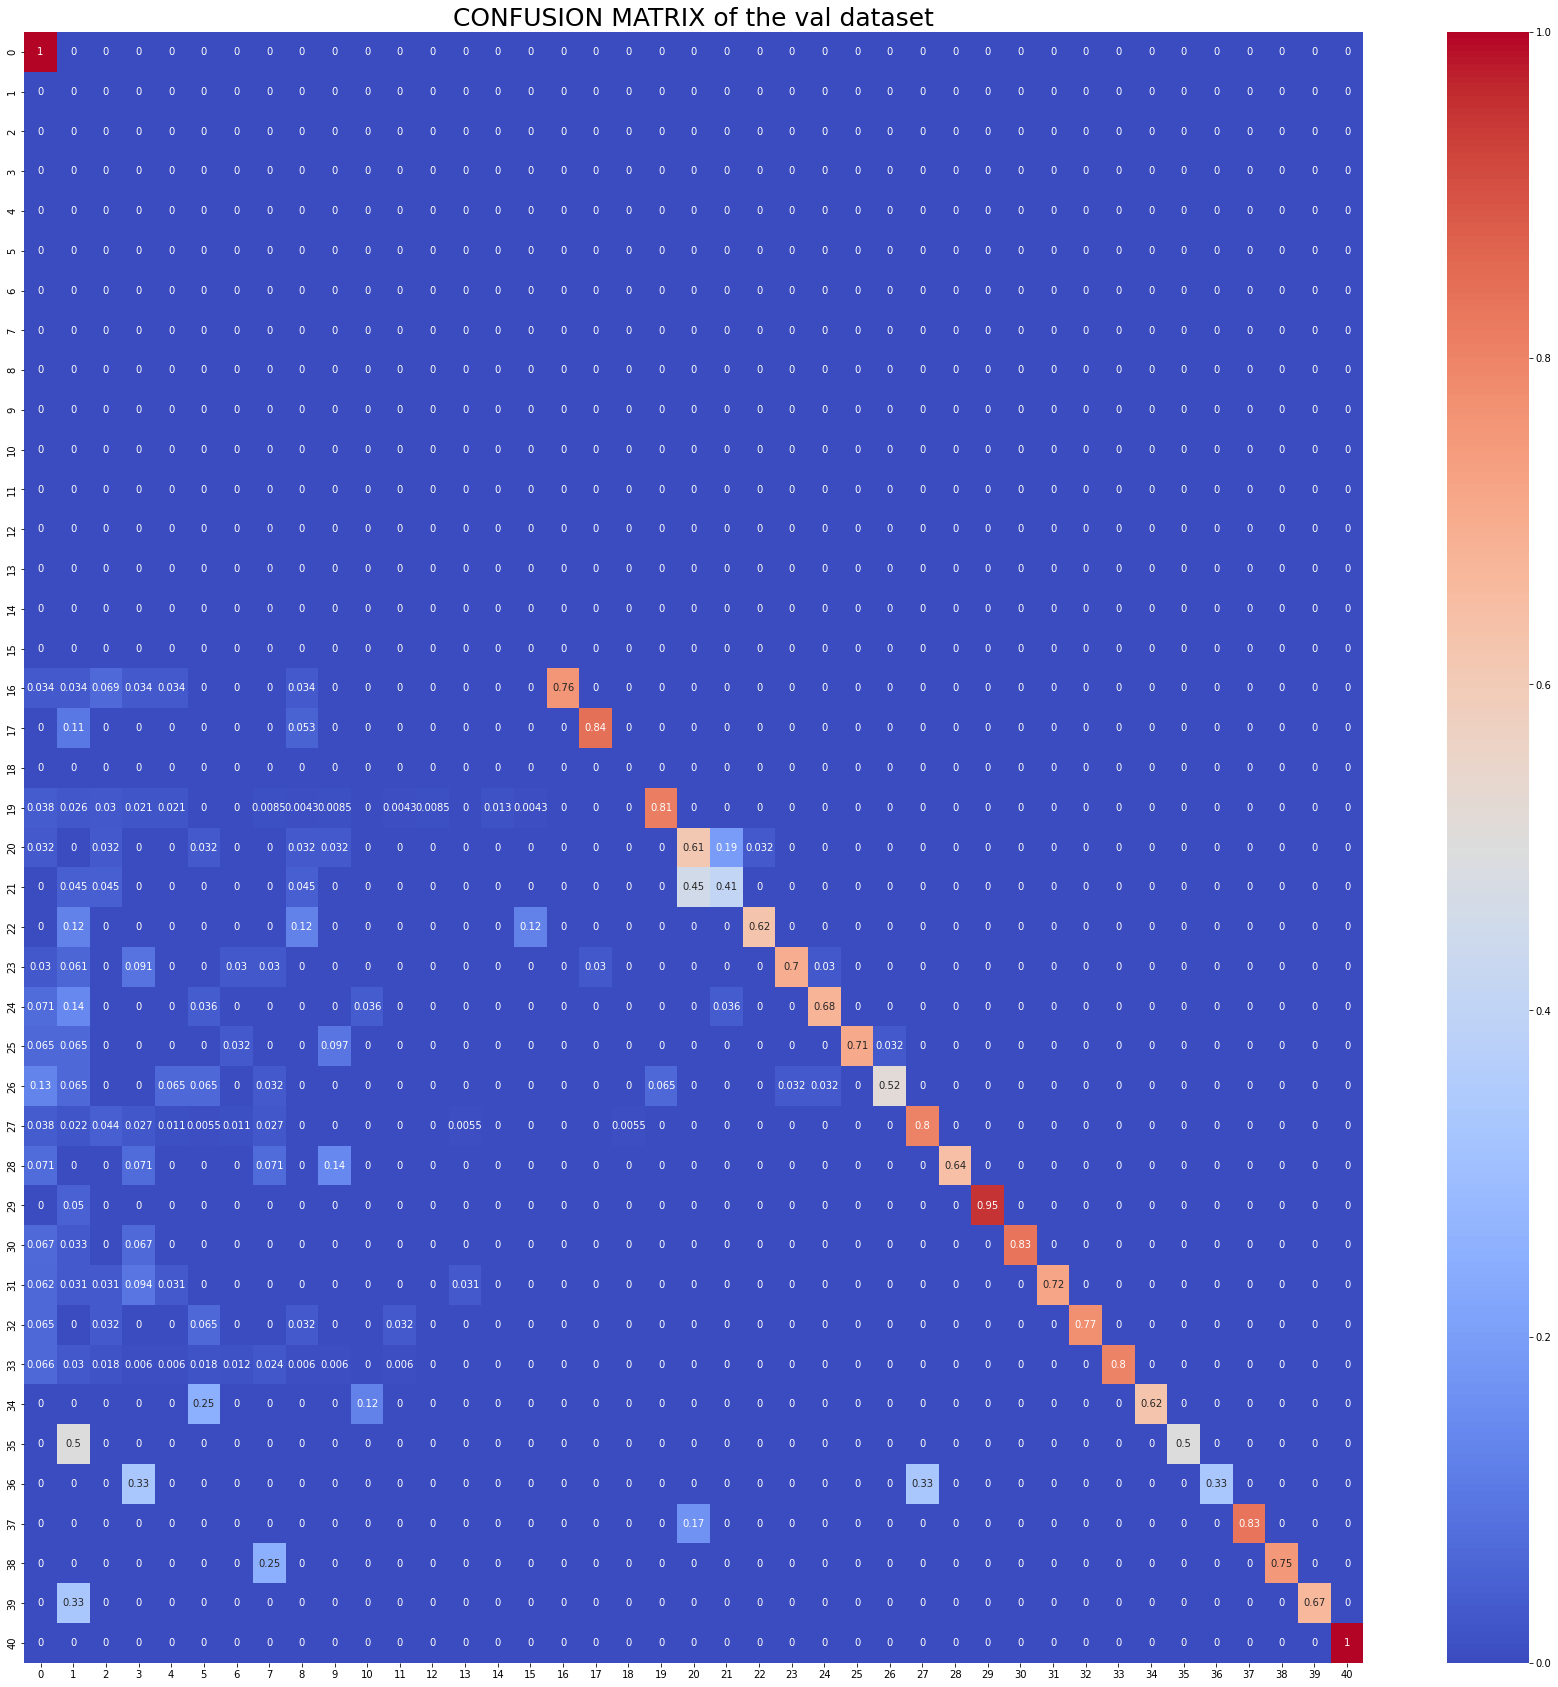

In [38]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(30, 30))
sns.heatmap(
    confusion_matrix(
        val_y_true,
        val_y_pred,
        normalize = 'true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()

# Test / 제출 파일 생성

In [75]:
# def predict(loader):
#     model.eval()
#     results = []

#     for batch, batch_item in enumerate(tqdm(loader)):
#         img = batch_item['img'].to(device)
#         seq = batch_item['csv_feature'].to(device)
#         with torch.no_grad():
#             output = model(img, seq)
#         output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
#         results.extend(output)    
#     return results

# model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)
# model.load_state_dict(torch.load(save_path, map_location=device))
# model.to(device)

# preds = predict(test_dataloader)
# # 25min

In [76]:
# preds = np.array([label_decoder[int(val)] for val in preds])

In [77]:
# submission = pd.read_csv('data/sample_submission.csv')
# submission['label'] = preds
# submission

In [78]:
# submission.to_csv(f'{save_name}_{np.max(val_score_list):.6f}.csv', index=False)